### Plot the full-shape results: Shape-Fit(SF) and Full-modeling(FM)

In [1]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import numpy as np
from getdist import plots
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
# %config InlineBackend.figure_format = 'retina'
%matplotlib inline

from cosmoprimo.fiducial import DESI, AbacusSummit
from desilike.samples import plotting, Chain
from desilike import setup_logging
setup_logging()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
sys.path.append('/global/homes/s/shengyu/project_rc/main/Y3/')
from helper import REDSHIFT_VSMEAR, REDSHIFT_CUBICBOX, EDGES, RSF_CUBIC_ERROR, GET_RECON_BIAS
from helper import REDSHIFT_LSS_VSMEAR, REDSHIFT_LSS_CUBICBOX, PLANCK_COSMOLOGY, COLOR_TRACERS
from fit_cubic_tools import get_observable_likelihood, load_mock_cov, load_cubic_sys_fns, load_bins
from plotting_tools import plot_observable, plot_mcmc_walkers, convert_chain
%load_ext autoreload
%autoreload 2

Z_VSMEAR = REDSHIFT_LSS_VSMEAR # REDSHIFT_VSMEAR or REDSHIFT_LSS_VSMEAR (LSS z bins)
Z_CUBIC = REDSHIFT_LSS_CUBICBOX # REDSHIFT_CUBICBOX or REDSHIFT_LSS_CUBICBOX
base_dir = '/pscratch/sd/s/shengyu/results/cubic'

[000007.75] [0/1] 05-12 07:21  Chain                     INFO     Loading /pscratch/sd/s/shengyu/results/cubic/FM/LCDM/chain_QSO_z0.8-2.1_standard_vel_rscov.npy.
[000013.45] [0/1] 05-12 07:21  Chain                     INFO     Loading /pscratch/sd/s/shengyu/results/cubic/FM/LCDM/chain_QSO_z0.8-2.1_dv-obs_vel_rscov.npy.


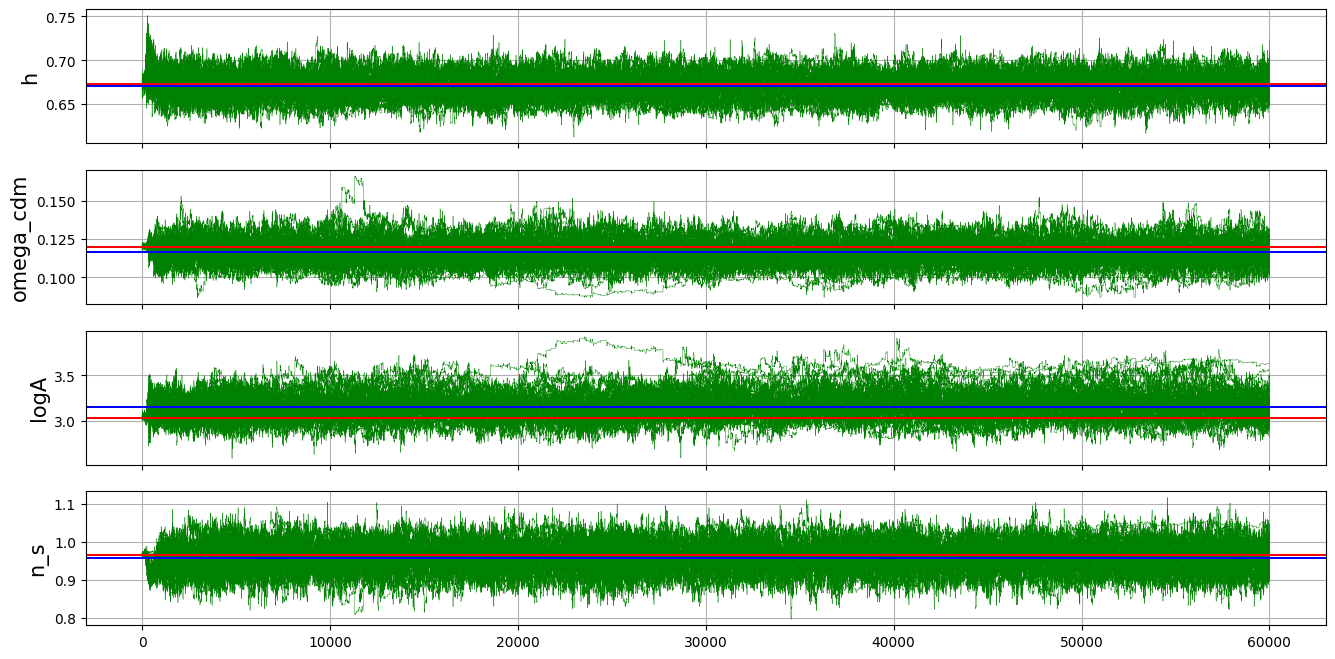

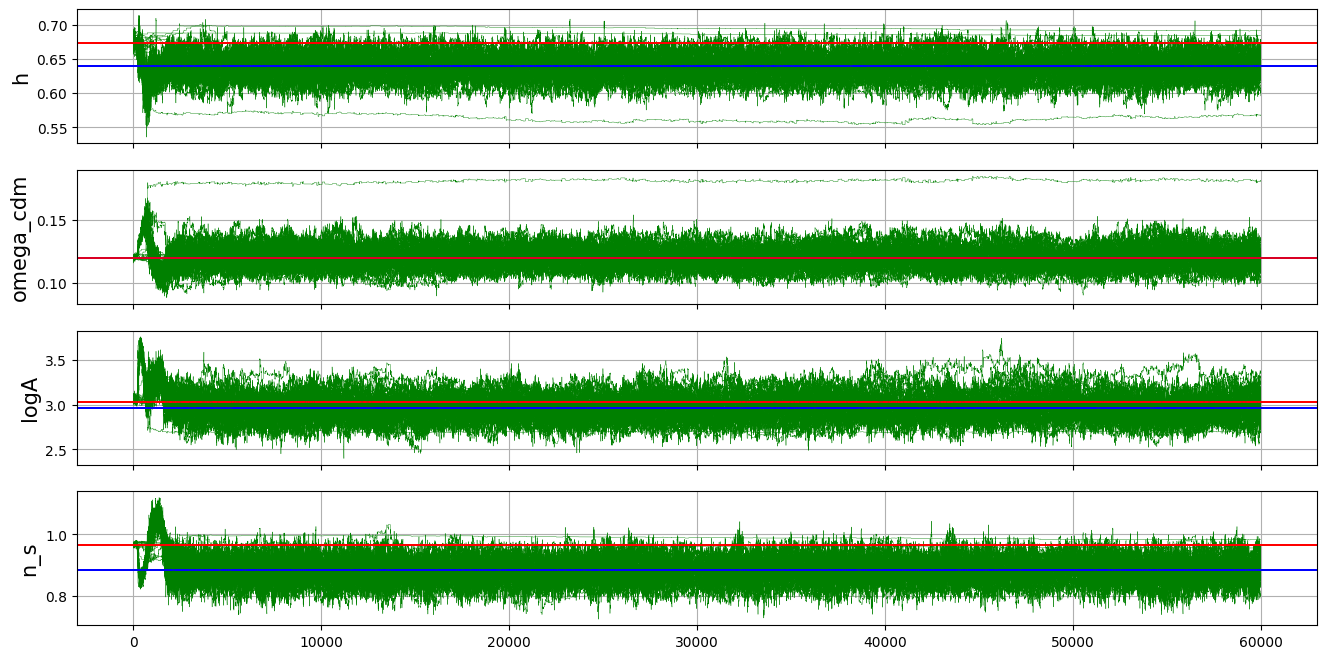

In [15]:
fit = 'FM' # SF or FM
task = f'{fit}fit_cubic_sys' #SFfit_cubic_sys, FMfit_cubic_sys
theory_model = 'vel' # vel, folps
cov_type = 'EZcov_fn_rsf' # EZcov_fn, EZcov_fn_rsf
bins_type = 'y3_sys'
option = 'None' # _4.5logA, _5.0logA, _fix_ns, _dv_obs

tracer = 'QSO'
sys_models = ['standard','dv-obs']

if 'FM' in task:
    params = ['h', 'omega_cdm', 'logA', 'n_s']
    if 'fix_ns' in option:
        params = ['h', 'omega_cdm', 'logA']
    nwalkers = 64  # len(likelihood.varied_parmas)*4
    true_values = [PLANCK_COSMOLOGY[param] for param in params]
elif 'SF' in task:
    params = ['qiso', 'qap', 'dm', 'df']
    nwalkers = 64 # len(likelihood.varied_parmas)*4
    true_values = [1, 1, 0, 1]

# zz = [0]
for z_eff, (zmin, zmax) in zip((Z_CUBIC[tracer]), (Z_VSMEAR[tracer])):
# for z_eff, (zmin, zmax) in zip(np.array(Z_CUBIC[tracer])[zz], np.array(Z_VSMEAR[tracer])[zz]):
    for sys_model in sys_models:
        if 'rsf' in cov_type:
            chain_fn = base_dir+f'/{fit}/LCDM/chain_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}_{theory_model}_rscov.npy'
            if option != 'None':
                chain_fn = base_dir+f'/{fit}/LCDM/extra/chain_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}_{theory_model}_rscov{option}.npy'
        else:
            chain_fn = base_dir+f'/{fit}/LCDM/chain_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}_{theory_model}.npy'
        chain   = Chain.load(chain_fn)
        # true_values = [PLANCK_COSMOLOGY[param] for param in params]
        plot_mcmc_walkers(chain, params, nwalkers, true_values)

Loading exist EZmocks covariance
Cov_fn: /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/pk/cov_EZmocks_1.5Gpc_pk02_QSO_z0.8-2.1_k0.02-0.2_rsfDR2.txt
[000053.15] [0/1] 05-12 07:21  Emulator                  INFO     Loading /pscratch/sd/s/shengyu/results/cubic/emulator/emulator_FM_QSO_z0.8-2.1_vel_rscov.npy.
[000053.34] [0/1] 05-12 07:21  TracerPowerSpectrumMultipolesObservable INFO     Loading 25 files [/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph021/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph017/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph019/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_m

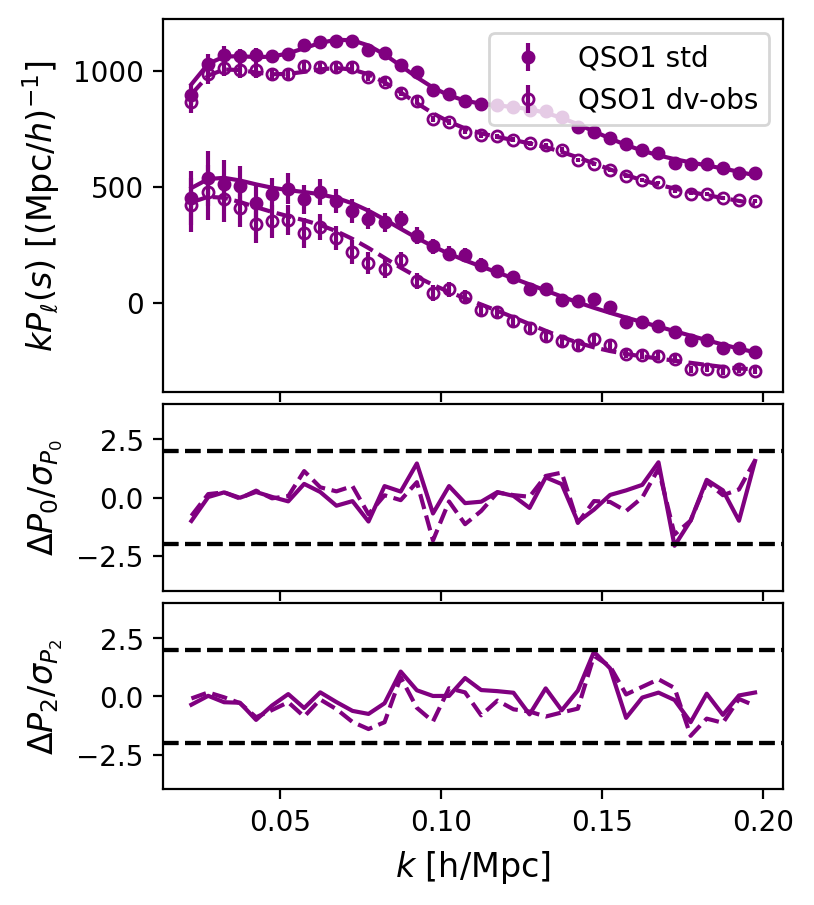

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
burnin = 0.5

plt.rcParams['legend.fontsize'] = 10
lenfig = len(Z_VSMEAR[tracer])
fig, ax = plt.subplots(3, lenfig, figsize = (lenfig*4,5), sharex=True, gridspec_kw={'height_ratios': [2,1,1]})
if lenfig == 1:
    ax = ax[:,np.newaxis]
fig.subplots_adjust(wspace=0.03, hspace=0.05) 
for i,(zmin, zmax) in enumerate(Z_VSMEAR[tracer]):
    z_eff = Z_CUBIC[tracer][i]
    color = COLOR_TRACERS[tracer][i]
    for s,sys_model in enumerate(sys_models):
        if 'rsf' in cov_type:
            emulator_fn = base_dir+f'/emulator/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}_rscov.npy'
            chain_fn = base_dir+f'/{fit}/LCDM/chain_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}_{theory_model}_rscov.npy'
            if option != 'None':
                emulator_fn = base_dir+f'/emulator/extra/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}_rscov{option}.npy'
                chain_fn = base_dir+f'/{fit}/LCDM/extra/chain_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}_{theory_model}_rscov{option}.npy' 
        else:
            emulator_fn = base_dir+f'/emulator/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}.npy'
            chain_fn = base_dir+f'/{fit}/LCDM/chain_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}_{theory_model}.npy'
        fit_args = fit_args = {"corr_type": 'pk', "bins_type": bins_type, "cov_type": cov_type, "theory_model":theory_model, 'emulator_fn':emulator_fn}
        linestyles = ['-', '--']
        data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "sys_model": sys_model, "grid_cosmo": '000'}
        plot_kwargs = {'color': color, 'linestyle':linestyles[s], 'sys_model':sys_model, 'corr_type':'pk', "index":i}
        plot_kwargs.update(data_args)
        (likelihood, observable, _) = get_observable_likelihood(task, data_args, fit_args)
        chain   = Chain.load(chain_fn)
        likelihood(**chain.choice(index='argmax', return_type='dict', input=True))
        ax_top = ax[0][i]
        ax_bottom = [ax[1][i], ax[2][i]]
        plot_observable(observable, ax_top, ax_bottom, **plot_kwargs)
        if i>0:
            for ill in range(3):
                ax[ill][i].tick_params(axis='y', which='both', left=False, labelleft=False)
                ax[ill][i].set_ylabel(None)

In [9]:
burnin = 0.5
z = 0
(zmin, zmax)  = Z_VSMEAR[tracer][z]
z_eff = Z_CUBIC[tracer][z]
for sys_model in sys_models:
    if 'rsf' in cov_type:
        emulator_fn = base_dir+f'/emulator/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}_rscov.npy'
        chain_fn = base_dir+f'/{fit}/LCDM/chain_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}_{theory_model}_rscov.npy'
        if option != 'None':
            emulator_fn = base_dir+f'/emulator/extra/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}_rscov{option}.npy'
            chain_fn = base_dir+f'/{fit}/LCDM/extra/chain_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}_{theory_model}_rscov{option}.npy' 
    else:
        emulator_fn = base_dir+f'/emulator/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}.npy'
        chain_fn = base_dir+f'/{fit}/LCDM/chain_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}_{theory_model}.npy'
    fit_args = fit_args = {"corr_type": 'pk', "bins_type": bins_type, "cov_type": cov_type, "theory_model":theory_model, "emulator_fn":emulator_fn}
    data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "sys_model": sys_model, "grid_cosmo": "000"}
    (likelihood, observable, _) = get_observable_likelihood(task, data_args, fit_args)
    chain = Chain.load(chain_fn).remove_burnin(burnin)
    likelihood(**chain.choice(index='argmax', return_type='dict', input=True))
    print(chain.to_stats(tablefmt='pretty'))
    print('chi2:',-2*likelihood(**chain.choice(index='argmax', return_type='dict', input=True)))

Loading exist EZmocks covariance
/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/pk/cov_EZmocks_1.5Gpc_pk02_QSO_z0.8-2.1_k0.02-0.2_rsfDR2.txt
[000073.92] [0/1] 05-12 01:41  Emulator                  INFO     Loading /pscratch/sd/s/shengyu/results/cubic/emulator/emulator_FM_QSO_z0.8-2.1_vel_rscov.npy.


[000074.20] [0/1] 05-12 01:41  TracerPowerSpectrumMultipolesObservable INFO     Loading 25 files [/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph021/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph017/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph019/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph020/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph012/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy].
[000074.61] [0/1] 05-12 01:41  Chain                    

[000448.03] [0/1] 05-12 01:34  Chain                     INFO     Loading /pscratch/sd/s/shengyu/results/cubic/SF/LCDM/chain_QSO_z0.8-2.1_standard_vel_rscov.npy.


[000448.48] [0/1] 05-12 01:34  Chain                     INFO     Loading /pscratch/sd/s/shengyu/results/cubic/SF/LCDM/chain_QSO_z0.8-2.1_dv-obs_vel_rscov.npy.
Removed no burn in
Removed no burn in


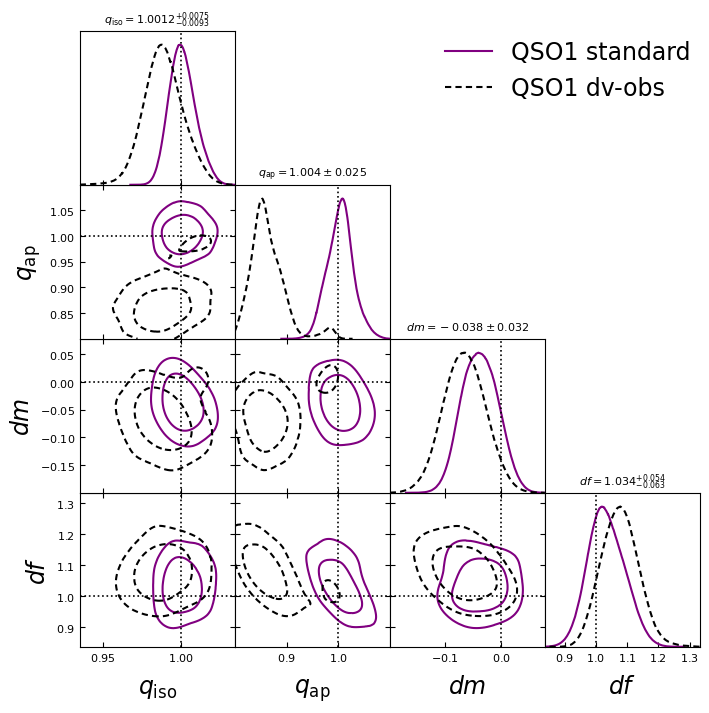

In [5]:
# plot the contour plot
%matplotlib inline
burnin = 0.6
color = COLOR_TRACERS[tracer][z]
filled = True if fit == 'FM' else False

if tracer == 'LRG':
    slice_step = 4500
    param_limits = {'h':[0.62,0.74],'omega_cdm':[0.07,0.18],'logA':[2.5,3.6], 'n_s':[0.8,1.1], 'b_1':[0.9, 1.2]}
elif tracer == 'ELG':
    slice_step = 4550
    param_limits = {'h':[0.62,0.74],'omega_cdm':[0.07,0.18],'logA':[2.5,3.6], 'n_s':[0.8,1.1]}
elif tracer == 'QSO':  
    slice_step = 5000
    param_limits = {'h':[0.56,0.74],'omega_cdm':[0.08,0.16],'logA':[2.4,3.8], 'n_s':[0.8,1.1]}
    
sys_models = ['standard','dv-obs']
chains   = []
for sys_model in sys_models:
    if 'rsf' in cov_type:
        # if sys_models == 'dv_obs':
            # slice_step = 3000
        chain_fn = base_dir+f'/{fit}/LCDM/chain_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}_{theory_model}_rscov.npy'
        if option != 'None':
            chain_fn = base_dir+f'/{fit}/LCDM/extra/chain_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}_{theory_model}_rscov{option}.npy' 
    else:
        chain_fn = base_dir+f'/{fit}/LCDM/chain_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}_{theory_model}.npy'
    chain = Chain.load(chain_fn).remove_burnin(burnin)[::slice_step]
    chains.append(chain)

g = plots.get_subplot_plotter()
g.settings.fig_width_inch= 8
# g.settings.fig_width_inch= 16
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.settings.figure_legend_frame = False
labels  = [f'{tracer}{z+1} standard', f'{tracer}{z+1} dv-obs']
plotting.plot_triangle(chains, title_limit=1, filled = filled, 
                       params = params,
                       legend_labels = labels, legend_loc= 'upper right',
                       contour_lws = 1.5, contour_colors = [color, 'black'],contour_ls = ['-', '--'],
                        # param_limits=param_limits, 
                        smoothed=True, show=False, g=g)
def set_true_values(fit, params):
    if fit == 'SF':
        return [1,1,0,1]
    if fit == 'FM':
        return [PLANCK_COSMOLOGY[param] for param in params if param in PLANCK_COSMOLOGY]
true_values     = set_true_values(fit, params)
for i in range(len(true_values)):
    for j in range(i+1):
        g.subplots[i,j].axvline(true_values[j], c = 'k', ls = ':', lw = 1.2)
        if i != j:
            g.subplots[i,j].axhline(true_values[i], c = 'k', ls = ':', lw = 1.2)